## Chapter 7 : Learning from Images --> Telling birds from airplanes
* Building a feed forward neural network
* Loading data using dataloaders and dataset.
* Understanding the classification loss.

In the previous chapter we saw what the mechanics of pytorch are by building a simple linear model and using gradient descent to optimize it. In this chapter we will use the Neural Network for an image recognition task. We will load a small dataset of images and try to classify them.

##### Working with images : Introduction to CIFAR_10
1. CIFAR_10 is like a sibling of CIFAR_100. It consists of 60,000 images of 32x32 size and they belong to 10 classes.
2. We would use the torchvision module to automatically download the dataset and load it as a collection of pytorch tensors.

#### Downloading the CIFAR_10 dataset
As we discussed let's import the torchvision module and download the datasets module to download the dataset.

In [1]:
import torch
from torchvision import datasets

data_path = "./datasets/CIFAR_10/"
cifar10 = datasets.CIFAR10(data_path, download=True, train=True)
cifar10_val = datasets.CIFAR10(data_path, download = True, train=False)


Files already downloaded and verified
Files already downloaded and verified


1. The first argument to the datasets.CIFAR10 is the path that the data will be downloaded to.
2. The download argument tells pytorch to download the dataset if not found in the path provided in the first argument. 
3. The train argument is a boolean argument which specifies whether we are interested in downloading the training or the validation set.

Just like CIFAR10 the dataset module gives us access to some of the most well-known datasets like MNIST, Fashion-MNIST, CIFAR_100, SVHN, Coco, Omniglot, etc. In each case the data returned is a subclass of `torch.utils.data.Dataset`. We can see the method resolution order of our cifar10 instance includes it as a base class.

In [2]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

##### The Dataset class: A look into pytorch Datasets
This is a good time to see what a pytorch dataset is all about: It is a subclass of pytorch.uitls.data.Dataset. It is an object that is required to implement two methods. First is `__len__` and the second is `__getitem__`. The former should return the length of the dataset and the latter should return each item of the dataset consisting of an example and its corresponding label.\
`Note : For some use cases pytorch also provides us with an iterable dataset which is used in cases where random access to the dataset is prohibitively expensive, like data generated on the fly.`\
For images torchvision provides images in the PIL image format.

In [3]:
len(cifar10)

50000

Text(0.5, 1.0, 'automobile')

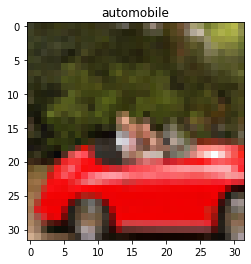

In [4]:
import matplotlib.pyplot as plt
import numpy as np
image, label = cifar10[99]

plt.imshow(image)
plt.title(cifar10.classes[label])

##### Dataset transform
Plotting the image is good but we would like to convert our data into pytorch tensors before we can do anything with it. This is where `torchvision.transform` comes in. It defines a set of funcitons that can be passed as arguments to a torchvision dataset and it can perform those transformations on the data after its loaded but before it is returned by `__getitem__`.

In [5]:
# We can see the list of available objects as follows
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

Among the above transfroms we have the ToTensor transfrom which transforms numpy and PIL images to tensors. It also takes care to lay out the dimensions of the output tensor as `C x H x W` (channel, height, width).

In [6]:
import numpy as np

# lets try out the ToTensor transform. Once instantiated it can be used by like a funciton by passing the image to it as an argument.
totensor = transforms.ToTensor()
print(f"Numpy image shape: {np.array(image).shape}")
image = totensor(image)
print(f"Pytorch tensor image shape : {image.shape}")

Numpy image shape: (32, 32, 3)
Pytorch tensor image shape : torch.Size([3, 32, 32])


In [7]:
# we can also pass the transform to the dataset directly. Then we would get returned a tensor instead of a PIL image
cifar10 = datasets.CIFAR10("./datasets/CIFAR_10/", download = False, transform=transforms.ToTensor(), train = True)
cifar10_val = datasets.CIFAR10("./datasets/CIFAR_10/", download = False, transform = transforms.ToTensor(), train = False)

In [8]:
image, label = cifar10[99]
print(type(image))
print(image.shape)

<class 'torch.Tensor'>
torch.Size([3, 32, 32])


The values for the untransformed image was 0-255 and it was an 8-bit integer. But the transformed images have float32 as their datatype and their values range from 0.0 to 1.0. We can verify that also

In [9]:
print(cifar10[99][0].dtype)
print(cifar10[99][0].min(), cifar10[99][0].max() )

torch.float32
tensor(0.) tensor(1.)


Text(0.5, 1.0, 'automobile')

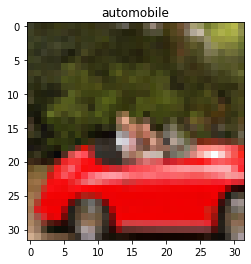

In [10]:
# Lets also verify that we are returning the same image as the output.
image_t, label_t = cifar10[99]
image_t = image_t.permute(1,2,0)   # changing from c*h*w to h*w*c because matplotlib.imshow() understands h*w*c format
plt.imshow(image_t)
plt.title(cifar10.classes[label_t])

##### Normalizing data
1. Transformation are really handy because we can chain the transformations usig transforms.Compose, they can handle transformation and augmentation directly in the dataloader. For instance it is handy for our data to have 0 mean and 1 standard deviation, because we will be choosing activation functions that are linear around 0 or -1 as lower limit and 1 as upper limit, then if the data falls within that range we would have a greater chance that the gradients are non-zero, and hence the model will learn sooner.
2. Also normalizing each channel so that it has the same distribution will ensure that channel information can be mixed and updated using the same learning rate.
3. In order to normalize the dataset we will need to compute the mean and standard deviation of the data and apply the transform
``` 
                                        data[c] = (data[c]-mean[c])/std_dev[c]
```
This is what transform.Normalize() does, but the values for `mean` and `std_dev` should be computed offline because the transform does not compute them.

In [11]:
# Now we would compute the mean and std_dev of the cifar10 dataset. Since it is small dataset we can manipulate it in memory.
# Now we would stack all of the tensors along an extra dimension, dimension 3.
images = torch.stack([img for img,_ in cifar10], dim = 3)
print(images.shape)
print(images[0])

torch.Size([3, 32, 32, 50000])
tensor([[[0.2314, 0.6039, 1.0000,  ..., 0.1373, 0.7412, 0.8980],
         [0.1686, 0.4941, 0.9922,  ..., 0.1569, 0.7294, 0.9255],
         [0.1961, 0.4118, 0.9922,  ..., 0.1647, 0.7255, 0.9176],
         ...,
         [0.6196, 0.3569, 0.9922,  ..., 0.3882, 0.6863, 0.8510],
         [0.5961, 0.3412, 0.9922,  ..., 0.3098, 0.6745, 0.8667],
         [0.5804, 0.3098, 0.9922,  ..., 0.3490, 0.6627, 0.8706]],

        [[0.0627, 0.5490, 1.0000,  ..., 0.2235, 0.7608, 0.8706],
         [0.0000, 0.5686, 1.0000,  ..., 0.1725, 0.7490, 0.9373],
         [0.0706, 0.4902, 1.0000,  ..., 0.1961, 0.7451, 0.9137],
         ...,
         [0.4824, 0.3765, 1.0000,  ..., 0.6118, 0.6784, 0.8745],
         [0.4667, 0.3020, 1.0000,  ..., 0.5529, 0.6706, 0.8902],
         [0.4784, 0.2784, 1.0000,  ..., 0.4549, 0.6549, 0.8235]],

        [[0.0980, 0.5490, 1.0000,  ..., 0.3843, 0.8157, 0.8353],
         [0.0627, 0.5451, 0.9961,  ..., 0.2510, 0.8039, 0.9176],
         [0.1922, 0.4510, 0

Now we can easily compute the mean/channel of the images. We can just keep the 3 channels and flatten out all the other dimension so that the matrix would be 3x1024. Then we take the mean of each channel over the 1024 elements is taken and we get the mean/channel. Same process is done for standard deviation also.

In [12]:
print(images.view(3,-1).shape)

torch.Size([3, 51200000])


In [13]:
image_reshape = images.view(3, -1) # We give the first dimension here and the rest are figured out according to the shape.
images_mean = image_reshape.mean(dim = 1)  # The dim=1 means that we are taking the mean along the first dimension i.e adding every column value
print(images_mean)
images_std = image_reshape.std(dim=1)
print(images_std)


tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


Now we have all the values, we can initialize the normalize transform and normalize our images across all 3 channels our dataset.

In [14]:
normalize =  transforms.Normalize(images_mean, images_std)
normalize

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

Then we can apply it at the time of creating the dataset and we would `concatenate` it to the `ToTensor()` transform.

In [15]:
transformed_cifar10 = datasets.CIFAR10("./datasets/CIFAR_10/",
                                        download= False,
                                        train = True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(images_mean, images_std)]))


transformed_cifar10_val = datasets.CIFAR10("./datasets/CIFAR_10/",
                                        download= False,
                                        train = False,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(images_mean, images_std)]))
                                                                    

Now we will plot an image from the transformed dataset and see how the smae image looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'automobile')

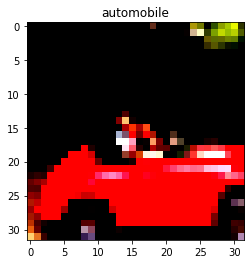

In [16]:
image, label = transformed_cifar10[99]
plt.imshow(np.array(image.permute(1,2,0)))
plt.title(transformed_cifar10.classes[label])

We get a black colors because the normalization has shifted the values between -1 to 1 and changed the overall magnitude of the channels. It's just that matplotlib renders it as black. We would keep that in mind for the future.

### Distinguishing Birds from Planes
Jane our freind has set up cameras in the jungle south of the airport to click pictures of birds when they pass. But the passing planes also trigger the cameras and give out False positives. What she needs is an auotomated system that can distinguish between birds and planes. We have got the perfect dataset, that can distinguish between birds and airplanes and from that dataset we can just pick up the pictures for birds and planes and train our classifier.

#### Step 1 : Building the Dataset
This is the first step of any Machine Learning problem. First we need our data in the correct format. Currently what we have is a dataset of 50000 images belonging to 10 classes.
1. We could create a dataset subclass that only includes the birds and the planes, but the data for that is very small and as the dataset is also very small we could just filter out the images of the birds and the planes and just remap the labels so that they are contigous.

In [17]:
label_map = {0:0, 2:1}  # Birds are the zero class in  the dataset and 2 is the class number for planes.
class_names = ['airplanes', 'birds']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label == 0 or label == 2]
cifar_2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label == 0 or label == 2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'airplanes')

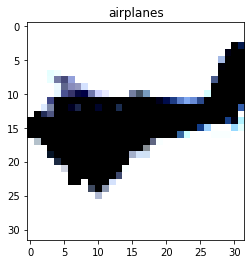

In [18]:
plt.imshow(np.array(cifar2[112][0].permute(1,2,0))) # reshape the image, convert to a numpy array and display
plt.title(class_names[cifar2[112][1]])              # display the title of the image.

The cifar2 object satisfies the criteria of a pytorch dataset i.e it has `__len__` and `__getitem__` methods. But this is done using a clever shortcut, if we run into some limitations with it we should implement a proper object of the dataset subclass. Now we have a dataset. We need to implement the model

#### Step 2 : Defining a fully Connected Model
Now we have the dataset ready and we need to feed the dataset into the model. Our model taking in an input which is tensor and outputs an output which is also a tensor. After all an image is just a set of numbers laid out in a Spatial configuration. If we take an image and stretch out its numbers in a 1D vector, we could consider those numbers as the input vector to our model.\
So lets start :-->
1. We will calculate how many input features per image i,e `3*32*32 = 3072`  features per image. So we will build a model which has 3072 input neurons and some hidden neurons. 1 neuron for each feature. Then we have a hidden layer of some neurons and then an acitvation layer and then we would have an output linear layer of neurons which would give us the correct number of outputs(2 for this case).
2. 

In [19]:
from typing import OrderedDict
import torch.nn as nn

n_out = 2

model = nn.Sequential(OrderedDict([
    ('Input Layer', nn.Linear(3072, 512)),
    ('Activation Layer', nn.Tanh()),
    ('Output Layer', nn.Linear(512,n_out))
]))

In [20]:
print(model)

Sequential(
  (Input Layer): Linear(in_features=3072, out_features=512, bias=True)
  (Activation Layer): Tanh()
  (Output Layer): Linear(in_features=512, out_features=2, bias=True)
)


So now we have a model defined with the correct input, output and hidden features. Next we would discuss what the model output should be.

##### Step 3 : The Output of the classifier
In the thermomoeter experiment we output a predicted temperature(a quantitative number). We could do something similar here and cast our outputs to 0 and 1, 0 for birds and 1 for planes and use the MSE loss to calculate the value and if we do that we would turn this problem to a regression problem. But if we look at the problem closely we would find out that we do not have to predict the value, we just have to see if the image is a bird or a plane i.e the output is categorical, so what we can do is that we can switch to categorical variables and represent 0 for bird and 1 for plane and this would still work even if we had 10 classes. We would have a one-hot vector of length 10.

In an ideal case the network would output tensor([1.0, 0.0]) for bird and tensor([0.0, 1.0]) for a plane, but realisticly it would be somewhere in between, so we can interpret the output as probabilities that the first value is a bird and the second value is a plane.\
Casting out problems outputs into probabilities puts some constraints:
1. Each output should be in the range between [0.0, 1.0].
2. The sum of each of the classes probabilities should not be greater than 1.
This sounds like a very tough task to represent this in a differentiable way so that we can backpropagate, but there is a very smart trick that does that and it is called as `Softmax`.

##### Representing the output as probabilities : The `Softmax Function`
1. Softmax is a function that takes in a vector of values of a dimension and outputs another vector of the same dimension where the outputs satify the above constraints.
2. In the softmax function we take the vector and calculate the exponential of its individual elements and then we divide each element by the sum of the exponentials.
3. The softmax is a `monotone` function i.e lower values in the input will correspond to lower values in the output. However it is not `scale invariant` i.e the ratio between the values is not preserved. This is not an issue because the learning process of the model will drive the values in such a way that the ratio of the values is preserved.
4. The nn module makes softmax available as a submodule. As usual the input tensor may have a batch dimension along the 0th dimension ot they might have dimensions along which they encode probabilities and other dimensions along which they do not, so softamx requires us to pass the dimension as an argument to perform the softmax operation along that dimension.

In [21]:
# Lets test the softmax on an input vector
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()
x = torch.tensor([1.0,2.0, 3.0])
print(softmax(x))

# using the nn.Softmax module. In this case we have two input vectors along the 0th dimension so we are choosing to perform softmax on dim=1.
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0,2.0,3.0],
        [1.0,2.0,3.0]])
print(softmax(x))

tensor([0.0900, 0.2447, 0.6652])
tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


Excellent, now we can add softmax to the end of our model and the network will be equipped to output the class probabilities.

In [22]:
from typing import OrderedDict
import torch.nn as nn

n_out = 2

model = nn.Sequential(OrderedDict([
    ("Input Layer", nn.Linear(3072, 512)),
    ("Activation Layer", nn.Tanh()),
    ("Output Layer", nn.Linear(512,n_out)),
    ("Softmax Layer", nn.Softmax(dim=1))
]))

We can try running the model before even we train it to just see what result do we get.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


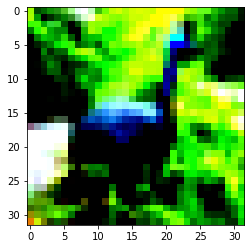

In [23]:
image, _ = cifar2[0]
plt.imshow(image.permute(1,2,0))

But before we input the image in the model we need to see if the image has the correct shape accepted by the model. So we know that it expects a tensor of 3072 dimensions and that nn module works with batches of data which is an extra index along the 0th dimension. So we flatten our image and add an extra dimension.

In [24]:
image = image.view(-1).unsqueeze(0)  # reshapes the image to a 1D vector and adds an extra dimension.

# Now we are ready to invoke our model
out = model(image)
print(out)

tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward0>)


1. We can see that our model outputs a pair of probabilities which it thinks are the correct ones, but the model has not been trained yet. It has just initialized some random numbers between -1.0 to 1.0 to the input. We can also see there is a grad_fn printed in the output. This is the function at the tip of the output and will be useful when we are trying to backpropagate.
2. Secondly we also don't know which probability is which i.e bird or airplane because it does not the network cannot associate a class to the output at this point. It is the responsibility of the loss function to associate meanings to these two numbers after backpropagation.
3. If labels are provided as 0:'bird' and 1:'airplane', then that is the order the outputs will be expected to take. Thus after training if we take the argmax of the output vector then that is the index of the label, the one which the network predicts most likely. Coviniently `torch.max` also provides the `max of a vector and the index at which it occurs in the vector` along the provided dimension. So we will provide the dimension of the vector and not along the batches i.e dim = 1 .

In [25]:
_, index = torch.max(out, dim = 1)
print(index)

tensor([1])


It says that the image is a plane. Now we have adapted our model to the current classification task by outputting class probabilities instead of discreet values. Now we need to start training the model which is just minimizing loss during training.

#### A loss for Classification
We have just discussed that the loss give  meaning to the output probabilities of the Model. Previously we used MSE as our loss metric. We could still use MSE and make the Model converge on [1.0, 0.0] or [0.0, 1.0] but we do not want that becuase that would be unnescesary optimization. We just want to penalize misclassification rather than painstakingly penalize anything that does not look like a 0.0 or 1.0

1. What we need to maximize in this case is the probability associated with the correct class. This quantity i.e the probability associated with the correct class is known as `likelihood(of model parameters given the data)`. In other words we want a loss function that is very high when the likelihood is low, so high that the other classes probabilities are higher that it and we are not fixated on driving the probility to 1.
2. There is a loss function that behaves that way, it's called as `Negative Log Likelihood(NLL).` It has the expression `NNL = -sum(out_i[c_i])` where sum is taken over n examples and the correct class for sampel i is c_i.
3. When low probabilities are assigned to the data, NLL grows to infinity, while is grows shallow when the assigned probabilities are above 0.5. Remember that NLL takes probabilities as inputs, so as the likelihood increases other probabilities will nescessarily decrease.

Summing up our classification can be computed as follows.
1. Compute the forward pass.
2. apply the softmax function to compute the class probabilites.
3. Get the probabilities of the correct class(likelihood). We know the correct classes because it is a supervised problem.
4. `Compute its logarithm`, `slap a - sign` in front of it and `add it to the loss`.
\
\
But how do we compute these probabilites in pytorch. Pytorch has nn.NLLLoss class. However it takes a tensor of log probabilities as input, It then computes the NLL of our model given the batch of our data. `There is a good reason behind this convention : because taking the logarithm of a probability is tricky when the probability goes very close to zero. The workaround is to use nn.LogSoftmax instead of nn.Softmax which takes care to make the calculation numerically stable.

In [26]:
# We now need to modify our model to include nn.LogSoftmax instead of nn.Softmax
from typing import OrderedDict
import torch.nn as nn

n_out = 2

model = nn.Sequential(OrderedDict([
    ("Input Layer", nn.Linear(3072, 512)),
    ("Activation Layer", nn.Tanh()),
    ("Output Layer", nn.Linear(512,n_out)),
    ("Log_Softmax Layer", nn.LogSoftmax(dim=1))
]))

# Then we instantialte or NLL loss function
loss = nn.NLLLoss()

The loss takes two arguments : 
1. The tensor of log-probabilites of a batch of images from the LogSoftmax layer 
2. A vector of class_indices(0 and 1 in this case because we have two classes)
\
\
We can now test it with our bird images

In [27]:
image, label = cifar2[0]

# Flattening the image and adding a batch dimension and then passing it to our mode to get the probability tensor
pred = model(image.view(-1).unsqueeze(0))

# Calculating how much the probability differs from the actual label
loss(pred, torch.tensor([label]))

tensor(0.5747, grad_fn=<NllLossBackward0>)

In [28]:
label

1

From above we can see that the network is only 50% sure that it is a bird, because the ground truth label says that the image is a bird.

##### Cross-Entropy vs MSE
Now We can compare how the cross-entropy loss is better than the MSE : 
1. Even for correct classes, cross-entropy loss has some margin for error. The correct class is assigned a prbability of 99.97%, but MSE get saturated very easily, many times even for the wrong input it says that the classes are correct.
2. The reason for the above point is that the slope of MSE is often too low to compensate for the flatness of the softamx for incorrect predictions.

#### Training the Classifier
Now we are ready to bring back the training loop and see how it trains.

There can be 3 different ways of training a classifier.
1. We train on the individual images, calculate the loss, backpropagate and update the parameters per image.
2. We train on individual images, accumulate the loss, accumulate the gradients and update the parameters once per epoch.
3. We train on idividual images in a batch of images, compute the loss and accumulate the gradients per batch and update the parameters once per batch.

In [29]:
# # Here we will try to update the gradients once per image
# # We would define the model
# from typing import OrderedDict
# import torch.nn as nn
# import torch.optim as optim

# n_out = 2

# # define the model
# model = nn.Sequential(OrderedDict([
#     ("Input_linear_layer", nn.Linear(3072,512)),
#     ("Activation_layer", nn.Tanh()),
#     ("Output_layer", nn.Linear(512, n_out)),
#     ("Log_Softmax_1", nn.LogSoftmax(dim=1))
# ]))

# # define the learning rate
# learning_rate = 0.1

# # define the optimizer
# optimizer_sgd = optim.SGD(model.parameters(), lr = learning_rate)

# # define the loss function
# nn_loss = nn.NLLLoss()

# # Now define the training loop
# def training_loop(n_epochs, optimizer, loss_fn, X_train):
#     for epoch in range(1, n_epochs+1):
#         # carry out the forward pass for each image in the dataset
#         for image, label in X_train:
#             # make the image in proper shape of the input for the model
#             input = image.view(-1).unsqueeze(0)
#             pred = model(input)

#             # compute the training loss
#             loss = loss_fn(pred, torch.tensor([label]))

#             # zero out the gradients of the optimizer
#             optimizer.zero_grad()

#             # carry out the backward pass
#             loss.backward()

#             # update the paramters
#             optimizer.step()

#         # compute the validation loss

#         # print the training and the validation loss
#         print(f"Epochs : {epoch} | Training loss : {loss}")

#     return

# training_loop(n_epochs=10, optimizer= optimizer_sgd, loss_fn = loss, X_train = cifar2)

In this training_loop we are calculating the forward pass, and then updating the gradients per image. However what is good dir

#### Next we would try to divide the dataset into minibatches and train and update the parameters per minibatch

In [30]:
print(len(cifar2))

10000


1. In our previous examples what we did is that we evaluated the gradients according to each image and updated the parameters per image. But the problem for this approach is that the direction for the gradient for reducing the loss for  one image might not be a good direction for reducing the loss for others. So what we do is that we shuffle the dataset into random batches of the data and estimate the gradients on a few samples at a time. This introduces a sort of randomness in the gradient descent. `This is called as Stochastic Gradient Descent`. It turns out that these gradient approximations of random batch of data, which are poor approximations of the whole dataset help in better convergence and prevents the optimization process from getting stuck in the local minima.
2. Shuffling the dataset ensures that the sample of the gradients computed at each step is representative of the whole dataset.
3. Typically the number of mini-batches is needed to be set previously and it is a hyperparameter that differs from problem to problem and the sie of memory or other computational constraints. It is a `hyperparamter` just like the learning rate.
4. In our training code previously we implement a minibatch of size 1, by picking 1 item from the dataset. The `torch.utils.data` module has a class that can help with shuffiling and  orgainizing data into minibatches : `DataLoader` Class.
5. The job of the dataloader class is to sample and return the data from the dataset giving us the flexibilty of a particular sampling strategy.
6. On a bare minimum the `dataloader` constructor takes in dataset as the input with the `batch_size` and `shuffle = True/False` which indicates that the data needs to be shuffled per epoch or not.
7. As the dataloader can be iterated we can use it in our inner training loop.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiate the dataloader class and provide it with the dataset, batch_size and shuffle arguments.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 32, shuffle = True)

# Define the model
model = nn.Sequential(OrderedDict([
    ("Input layer", nn.Linear(3072,512)),
    ("Activation_layer", nn.Tanh()),
    ("Output_layer", nn.Linear(512, n_out)),
    ("Log_softmax_1", nn.LogSoftmax(dim=1))
]))

# Define the loss function
loss_nll = nn.NLLLoss()

# Define the optimizer
optimizer_sgd = torch.optim.SGD(model.parameters(), lr = 1e-2, )

# define the batch_size
batch_size, n_epochs = 32, 100

# Define the training loop
def training_loop(n_epochs, dataloader, optimizer, loss_fn, model):
    # Run the loop for epochs
    for epoch in range(1, n_epochs+1):
        # get the image and labels from the dataloader
        for img, labels in dataloader:
            # get the batch_size
            batch_size = img.shape[0]

            # get the predictions of the model
            pred = model(img.view(batch_size, -1))

            # calculate the loss
            loss = loss_fn(pred, labels)

            # zero the gradients of the optimizer before backpropagating
            optimizer.zero_grad()

            # backpropagate through the loss
            loss.backward()

            # update the parameters
            optimizer.step()

            # print the training and the validation losses
        if epoch % 10 == 0:
            print(f"Epoch : {epoch} | Loss : {loss}")


# call the training loop
training_loop(n_epochs = n_epochs, dataloader = train_loader, optimizer=optimizer_sgd, loss_fn = loss_nll, model = model)



Epoch : 10 | Loss : 0.3541380763053894
Epoch : 20 | Loss : 0.15739838778972626
Epoch : 30 | Loss : 0.09402313828468323
Epoch : 40 | Loss : 0.05393235385417938
Epoch : 50 | Loss : 0.016827018931508064
Epoch : 60 | Loss : 0.01260560005903244
Epoch : 70 | Loss : 0.0056186397559940815
Epoch : 80 | Loss : 0.003184625646099448
Epoch : 90 | Loss : 0.006937910337001085
Epoch : 100 | Loss : 0.008527797646820545


We can see that the loss has gone down enough but we do not know whether it is low enough. So to test the correctness of our model,  we can check the accuracy of our model on the correct classification over the total.

In [46]:
# Now lets make a validatin set dataloader.
val_loader = torch.utils.data.DataLoader(cifar_2_val, shuffle = False, batch_size = 32)
correct = 0
total = 0

# now as we do not want to compute the gradients, we would use the torch.no_grad() context
with torch.no_grad():
    for img, labels in val_loader:
        # get the batch_size of the image
        batch_size = img.shape[0]

        # reshape the image accoring to the batch_size and the input. This inputs an expected tenor of (32, 3072) in the model.
        outputs = model(img.view(batch_size, -1))

        # get the predictions and the index of the class with the max probability in the output 
        _, max_predicted_index = torch.max(outputs, dim=1)

        # get the total labels in the batch
        total += labels.shape[0]

        # get the total number labels predicted correctly in the batch
        correct += int((max_predicted_index == labels).sum())

# print out the accuracy of the model.
print(f"Accuracy : {correct/total}")

Accuracy : 0.669


1. The accuracy on the validation set is not very high, but in the models defence we can say that it is relatively shallow model, so it is not able to find the subtle nuances in the data which can differentiate between a bird and a Plane. We would focus on improving our model later.
2.  What we can do is that we can add more layers to our model and getly taper the number of hidden neurons in the, so that the intermediate layers have a greater chance of squeezing out the information from the data.

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiate the dataloader class and provide it with the dataset, batch_size and shuffle arguments.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 32, shuffle = True)

# Define the model
model = nn.Sequential(OrderedDict([
    ("Input layer", nn.Linear(3072,512)),
    ("Activation_layer", nn.Tanh()),
    ("Output_layer", nn.Linear(512, n_out)),
    ("Log_softmax_1", nn.LogSoftmax(dim=1))
]))

# Define the loss function
loss_nll = nn.NLLLoss()

# Define the optimizer
optimizer_sgd = torch.optim.SGD(model.parameters(), lr = 1e-2, )

# define the batch_size
batch_size, n_epochs = 32, 100

# Define the training loop
def training_loop(n_epochs, dataloader, optimizer, loss_fn, model):
    # Run the loop for epochs
    for epoch in range(1, n_epochs+1):
        # get the image and labels from the dataloader
        for img, labels in dataloader:
            # get the batch_size
            batch_size = img.shape[0]

            # get the predictions of the model
            pred = model(img.view(batch_size, -1))

            # calculate the loss
            loss = loss_fn(pred, labels)

            # zero the gradients of the optimizer before backpropagating
            optimizer.zero_grad()

            # backpropagate through the loss
            loss.backward()

            # update the parameters
            optimizer.step()

            # print the training and the validation losses
        if epoch % 10 == 0:
            print(f"Epoch : {epoch} | Loss : {loss}")


# call the training loop
training_loop(n_epochs = n_epochs, dataloader = train_loader, optimizer=optimizer_sgd, loss_fn = loss_nll, model = model)

Epoch : 10 | Loss : 0.3814864158630371
Epoch : 20 | Loss : 0.11479400843381882
Epoch : 30 | Loss : 0.20899197459220886
Epoch : 40 | Loss : 0.02062891237437725
Epoch : 50 | Loss : 0.02024221606552601
Epoch : 60 | Loss : 0.014094071462750435
Epoch : 70 | Loss : 0.0018639344489201903
Epoch : 80 | Loss : 0.007711926009505987
Epoch : 90 | Loss : 0.004203984048217535
Epoch : 100 | Loss : 0.002794005209580064


In [49]:
# Lets write the validation code to check the accuracy of the improved model.
# Now lets make a validatin set dataloader.
val_loader = torch.utils.data.DataLoader(cifar_2_val, shuffle = False, batch_size = 32)
correct = 0
total = 0

# now as we do not want to compute the gradients, we would use the torch.no_grad() context
with torch.no_grad():
    for img, labels in val_loader:
        # get the batch_size of the image
        batch_size = img.shape[0]

        # reshape the image accoring to the batch_size and the input. This inputs an expected tenor of (32, 3072) in the model.
        outputs = model(img.view(batch_size, -1))

        # get the predictions and the index of the class with the max probability in the output 
        _, max_predicted_index = torch.max(outputs, dim=1)

        # get the total labels in the batch
        total += labels.shape[0]

        # get the total number labels predicted correctly in the batch
        correct += int((max_predicted_index == labels).sum())

# print out the accuracy of the model.
print(f"Accuracy : {correct/total}")

Accuracy : 0.815


Now we can see that the validation accuracy of the model has significantly improved from 66.9% to 81%, and that to with adding just two hidden layers, our model was able to better classify pictures into birds and planes.

1. The combination of nn.LogSoftmax and nn.NLLLoss(negative loglikelihood) is equivalent to using nn.CrossEntropyLoss(). This is particular to pytorch as The nn.NLLLoss computes the crossentropy loss but with log probability predictions as inputs whereas the nn.CrossEntropyLoss() takes score(sometimes called as logits) as inputs.
2. So technically both the losses are the negative log-likelihood of the model parameters given the data when our model predicts the softmax applied probabilities
3. `It is quite common to drop the nn.LogSoftmax() layer from the model and use nn.CrossEntoryLoss() as the loss_function.`
4. `Note that the numbers will be exactly the same as nn.LogSoftmax() and nn.NLLLoss, the only convienience being that we can compute the result in one swoop but the output will not be interpretable as probabilities. We will need to explicitly pass the output through a softmax to get that as probabilities.

We can see that our model has a very low loss on the training set but the accuracy is not very high on the validation se i.e it is memorizing the pictures of birds and planes but not generalizing very well. In short it is `overfitting`.\
1. Pytorch offers a quick way to look at how many paramters a model has by `model.parameters()` method. To find out how many elements are in each tensor instance we call the `numel()` method. Summing those gives us the total count. But we might want to also see if the tensors have the requires_grad attribute set to True. We might want to differentiate between the number of trainable parameters and non-trainable parameters.


In [52]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

The number of our model parameters in our latest fully connected model is about twice as our first model.\
The number of parameters of the first layer of an input Linear layer is 3072*1024 = 3145728. This means that our model would not scale well with the number of inputs. Because a `1024*1024`image would have 3.1 million input parameters and using a 1024 hidden parameters we go to 3 billion parameters. If we use 32-bit floats we are already at 12GB of GPU/CPU ram and we haven't even hit the second layer yet and calculated the gradients. That's just not going to fit on present day GPU's.

#### The limits of going Fully Connected
1. If we are using a linear model and using a image represented as vecotrs we are just relying on the combination of pixel values to be unique to be relevant to our task at hand, but we are not taking advantage of the spatial raltionship between our pixels i.e we are not using the information about how much distance one pixels is away from the other pixel i.e if one pixel is neighbouring to the other pixel and far away from the other.
2. A fully connected network will se an airplane image and would think that, a bright pixel at 1,1 and dark at 1,2 and dark at 1,3 and so on is a good indication of an airplane and would learn that, but the same if it is at the bottom of the screen, then it would again need to learn that the dark pixeld at 25,25,27 etc. is a good indication. So it would need to learn it again. `Being fully connected means that it is not Translation Invariant.` This means that a network trained to recognize a spitfire at 4,4 will not be able to recognize the same plane if it is at 8,8.
3. So to combat this problem we would need to augment the image in many ways so that the network has a chance to see planes all over the image and we would need to do so all over the image. But this augmentation comes at a cost, the number of parameters must be large enough to keep all the information about these augmentations.
4. So we need to find out a way so that our model has to save upon storing learning the pixel arrangement for all of these augmented images, rather it should learn in such a way that spatial information can also be utilised. Convolutional Networks help in these cases.